In [1]:
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns',None)

import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Exploratory Data Analysis

In [2]:
data_path = "data/healthcare-dataset-stroke-data.csv"
categorical_columns = [
                    "gender",
                    "ever_married",
                    "work_type",
                    "Residence_type",
                    "smoking_status"
                    ]

In [3]:
class CustomMLdataLoader(object):
    def __init__(
                self,
                data_path,
                categorical_columns
                ):
        self.data_path = data_path
        self.categorical_columns = categorical_columns

    def load_data(self):
        if self.data_path.endswith('.csv'):
            data = pd.read_csv(self.data_path)
        elif self.data_path.endswith('.xlsx'):
            data = pd.read_excel(self.data_path)
        else:
            raise ValueError('Data type not supported')
        self.data = data

    def preprocess_data(self):
        # Encoding categorical columns
        encoded = pd.get_dummies(self.data[self.categorical_columns], columns=self.categorical_columns)
        self.data = pd.concat([self.data, encoded], axis=1)
        self.data.drop(self.categorical_columns, axis=1, inplace=True)

        # Other preprocessing if needed
        self.data.drop('id', axis=1, inplace=True)
        
        # Standardizing numerical columns
        # pass

        # Handling missing values
        self.data.bmi = self.data.bmi.fillna(0)

    def split_data(self, test_size=0.2, random_state=42):
        data = self.data.copy()
        X = data.drop('stroke', axis=1)
        y = data.stroke
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test
    
    def oversample_data(self, X_train, y_train):
        ros = RandomOverSampler(random_state=42, sampling_strategy='minority')
        X_train, y_train = ros.fit_resample(X_train, y_train)
        return X_train, y_train
        


In [4]:
dataloader = CustomMLdataLoader(data_path, categorical_columns)
dataloader.load_data()

raw_data = dataloader.data.copy()
raw_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


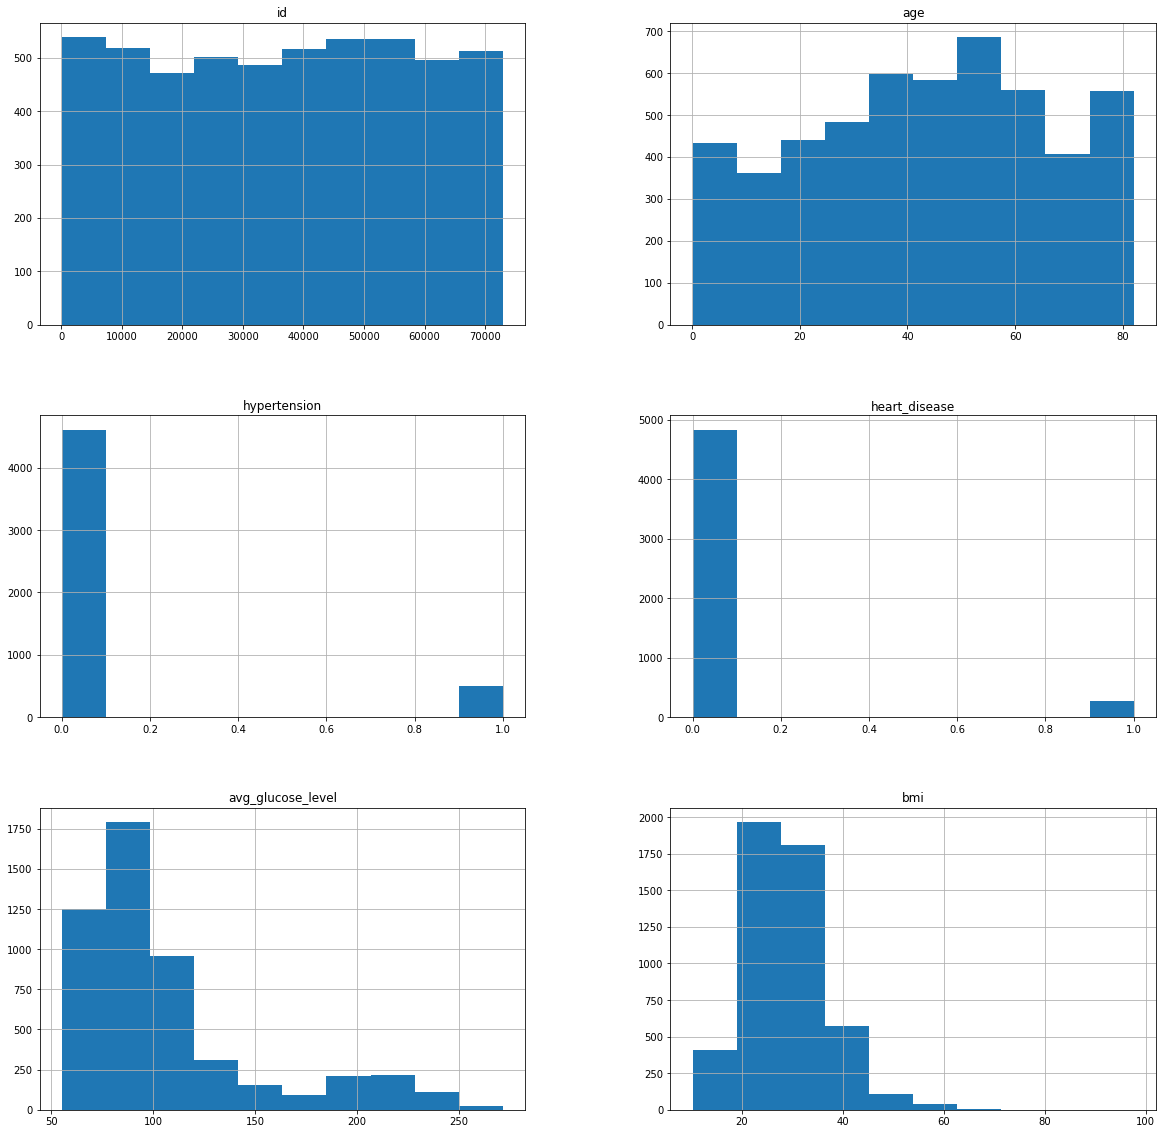

In [5]:
# plot the distribution of numerical columns
raw_data.drop('stroke', axis=1).hist(figsize=(20,20))
plt.show()

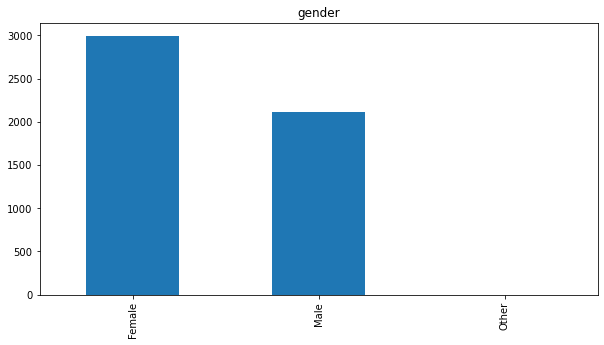

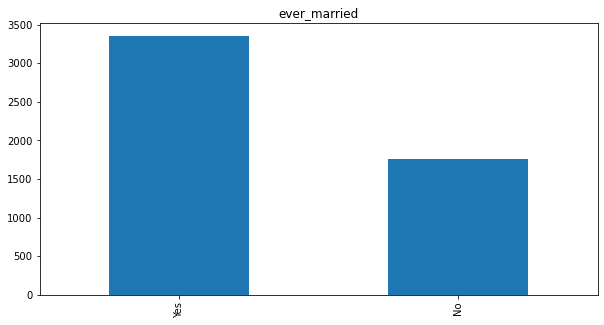

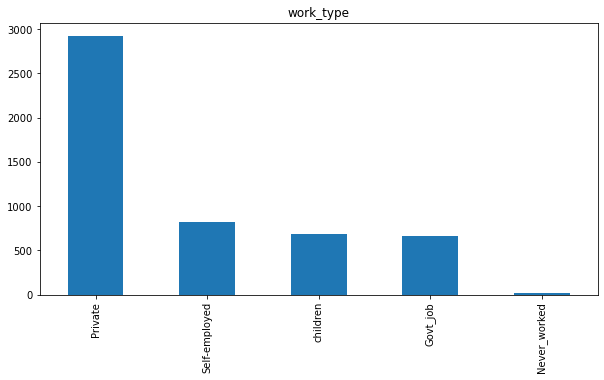

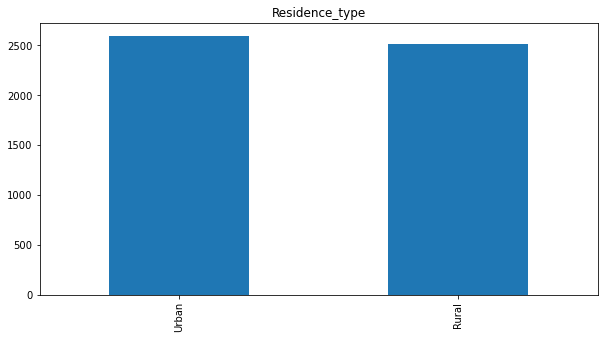

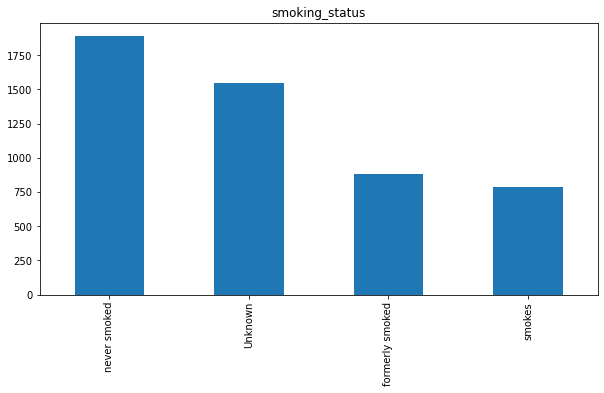

In [6]:
# plot the distribution of categorical columns
for col in categorical_columns:
    plt.rcParams['figure.figsize'] = (10, 5)
    raw_data[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()

# Preprocessing

In [7]:
dataloader.preprocess_data()
data_preprocessed = dataloader.data.copy()
data_preprocessed.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0
1,61.0,0,0,202.21,0.0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0


In [8]:
X_train, X_test, y_train, y_test = dataloader.split_data()
X_train, y_train = dataloader.oversample_data(X_train, y_train)

# Modeling

In [9]:
from interpret import show
from interpret.glassbox import (LogisticRegression,
                                ClassificationTree, 
                                ExplainableBoostingClassifier)
from sklearn.metrics import f1_score, accuracy_score

### 1. Logistic Regression

In [10]:
lg_reg = LogisticRegression(
                            random_state=42, 
                            max_iter=1000, 
                            feature_names=X_train.columns, 
                            penalty='l1', 
                            solver='liblinear'
                            )
lg_reg.fit(X_train.values, y_train)

In [11]:
P_lg_reg = lg_reg.predict(X_test.values)
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, P_lg_reg)}')
print(f'Logistic Regression F1 Score: {f1_score(y_test, P_lg_reg)}')

Logistic Regression Accuracy: 0.7553816046966731
Logistic Regression F1 Score: 0.27745664739884396


#### Explain local & global predictions

In [12]:
lg_reg_local = lg_reg.explain_local(X_test[:5], y_test[:5])
show(lg_reg_local)

<!-- http://127.0.0.1:7001/2040089368512/ -->

In [13]:
lg_reg_global = lg_reg.explain_global(name='Logistic Regression')
show(lg_reg_global)

<!-- http://127.0.0.1:7001/2040103585488/ -->

### 2. Decision Tree